# 增量式爬虫

可以对网站反复抓取，发现新东西就保存下来，遇到以前抓取过的内容自动过滤。其核心思想就是去重。

如，今天运行一下，明天运行一下，将运行过程中新的数据保存，相同的数据不再爬取。

去重的两种方案:
- 根据url去重
    
    在爬取时，如果这个url访问过，不再爬取。
- 根据数据去重

    在爬取时，需要将数据爬取到，然后扔到redis的set中，如果能扔进去，说明数据更新了；扔不进去说明数据已经存在。
    
    每次都会把数据从头到尾的撸下来。对url以及定死了，数据还更新的适用根据数据去重。如，论坛的回复内容。

网址：天涯社区  `http://bbs.tianya.cn/list.jsp?item=free&order=1`

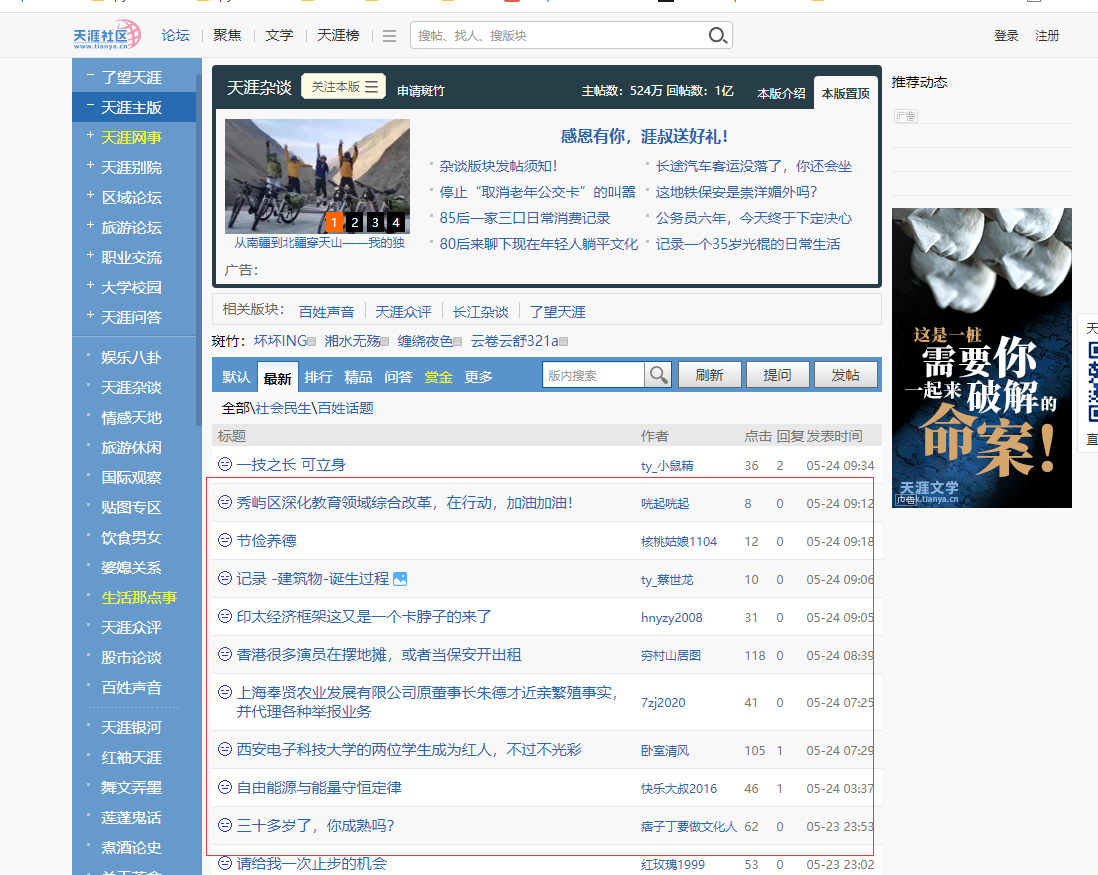

需求：

每天爬取最新的帖子，昨天的贴子可能还存在于第一页，每天爬取新帖时，要对以及爬取过的帖子去重。

抓取帖子中的主体类容，就是楼主发的东西。
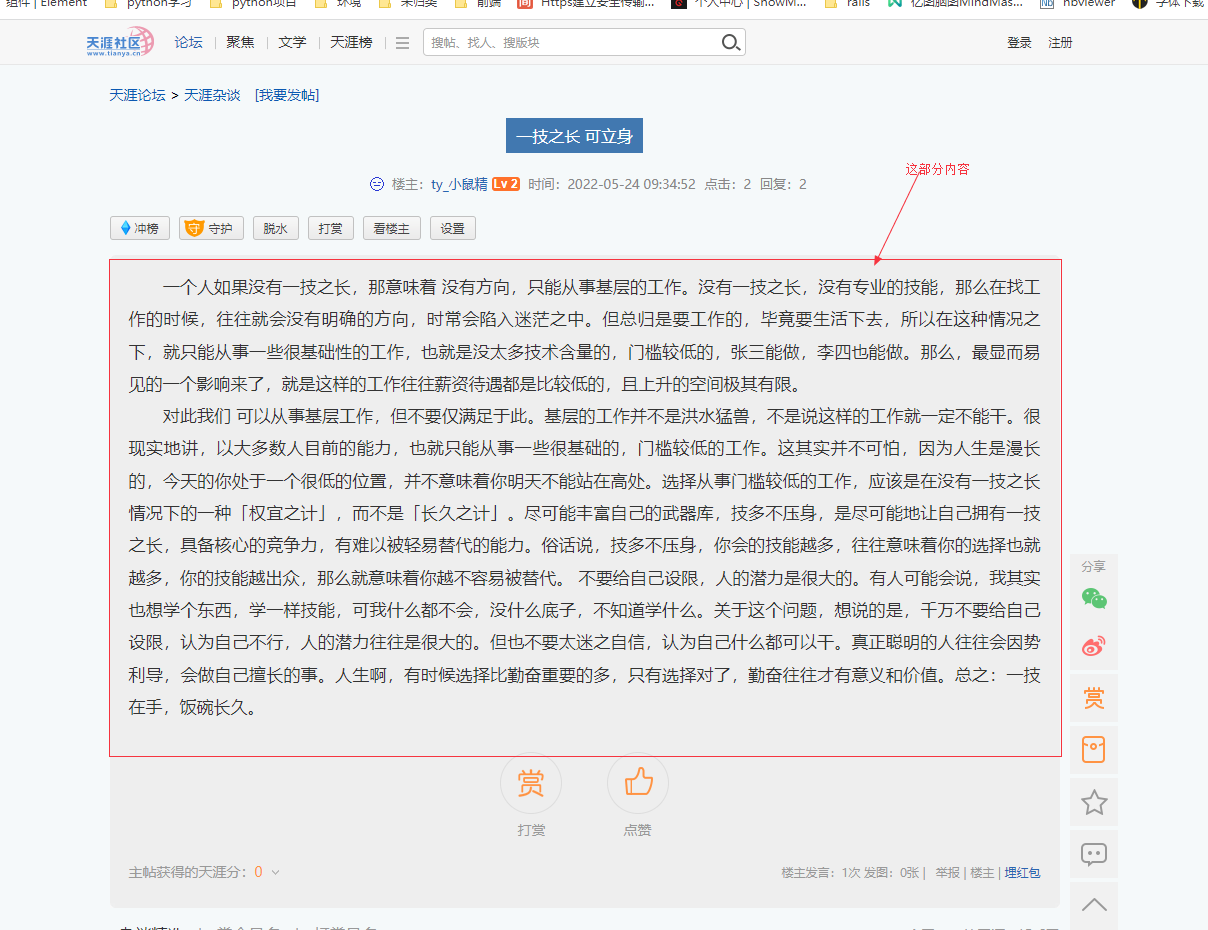

## 如何去除重复

scrapy的调度器是自带去除的，其用的是python的集合，在跑起来时，是可以去重的，但是其是内存层面的。 程序结束重新运行，内存中set保存的东西以及全被清楚了，所以不可用。

使用redis的set集合，其数据是保存在硬盘中的。

## url去重实现

### 思路

1.实现一个页面的抓取

该页面的所有帖子的url和帖子的详情数据。


2.redis链接的方式，在爬虫开始时，链接redis，在爬虫结束时关闭redis。

在中间件中，有一个给爬虫绑定信号的方法，在爬虫中也同样有这样的方法。
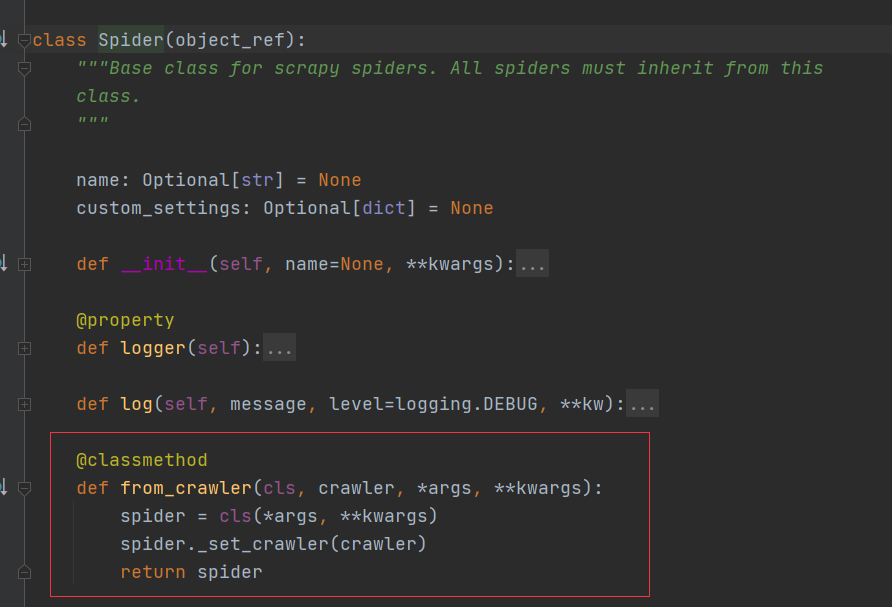
我们在爬虫中重写这个方法，绑定两个信号
- 在爬虫开始时，链接redis
- 在爬虫结束时，关闭redis

```python
@classmethod
def from_crawler(cls, crawler, *args, **kwargs):
    # This method is used by Scrapy to create your spiders.
    s = cls()
    crawler.signals.connect(s.spider_opened, signal=signals.spider_opened)
    crawler.signals.connect(s.spider_closed, signal=signals.spider_closed)
    return s

def spider_opened(self, spider):
    self.conn = Redis(host='127.0.0.1', port=6379, db=6)
    
def spider_closed(self, spider):
    if self.conn:
        self.close()
```


3.添加增量式，去重

在访问url的详情页时，先判断url是否在redis的set集合中，存在则跳过，不存在则抓取并保存url到redis中。
```python
# 判断是否在redis的集合中
self.conn.sismember(大key, url)

# 存储redis，在请求的响应回来的回调函数中对url进行存储.即给管道返回详情页的数据之前，进行保存。
self.conn.sadd(大key，resp.meta['href'])  # 不要用resp.url 因为可能存在页面跳转(重定向)
```

4.添加分页

在分页时，不能一直下一页，因为老早的数据我们可能以及爬过了，没有意义，所以要给出分页的边界。


控制页码的范围：
```python

def parse(self, resp, **kwargs):

    # 找到下一页的链接
    hh = "xxx.com"
    if resp.meta["page"] < 3:
        page = resp.meta["page"] + 1  # 页码加1
        yield Request(url=hh, callback=self.parse, meta={'page': page})
        
    else:
        pass
        
```

### 实现

1.实现一个页面的抓取
```python
import scrapy


class TySpider(scrapy.Spider):
    name = 'ty'
    allowed_domains = ['tianya.cn']
    start_urls = ['http://bbs.tianya.cn/list.jsp?item=free&order=1']

    def parse(self, resp, **kwargs):
        # 解析每个帖子的url
        tbodys = resp.xpath("//div[@class='mt5']/table/tbody")
        print(len(tbodys))
        for tbody in tbodys:
            trs = tbody.xpath("./tr")
            for tr in trs:
                title = tr.xpath("./td[1]//a/text()").extract_first()
                href = tr.xpath("./td[1]//a/@href").extract_first()
                if not title:
                    continue
                title = title.strip()
                href = resp.urljoin(href)
                print(title.strip(), href)

                yield scrapy.Request(url=href, callback=self.parse_detail)

    def parse_detail(self, resp, **kwargs):
        # 解析详情页的数据
        content = resp.xpath("//div[@class='bbs-content clearfix']//text()").extract()
        content = "".join(content).strip()
        print(content)
```

2.redis链接
```python
import scrapy
from scrapy import signals
from redis import Redis


class TySpider(scrapy.Spider):
    @classmethod
    def from_crawler(cls, crawler, *args, **kwargs):
        # This method is used by Scrapy to create your spiders.
        s = cls()
        crawler.signals.connect(s.spider_opened, signal=signals.spider_opened)  # 爬虫启动执行时，绑定一个事件来创建redis
        crawler.signals.connect(s.spider_closed, signal=signals.spider_closed)  # 爬虫结束时，绑定一个事件来关闭redis
        return s

    def spider_opened(self, spider):
        self.conn = Redis(host='127.0.0.1', port=6379, db=6)

    def spider_closed(self, spider):
        if self.conn:
            self.conn.close()
```

3.增量式，去重
```python
import scrapy
from scrapy import signals
from redis import Redis


class TySpider(scrapy.Spider):
    def parse(self, resp, **kwargs):
        # 解析每个帖子的url
        tbodys = resp.xpath("//div[@class='mt5']/table/tbody")
        print(len(tbodys))
        for tbody in tbodys:
            trs = tbody.xpath("./tr")
            for tr in trs:
                title = tr.xpath("./td[1]//a/text()").extract_first()
                href = tr.xpath("./td[1]//a/@href").extract_first()
                if not title:
                    continue
                title = title.strip()
                href = resp.urljoin(href)
                print(title.strip(), href)
                # 1. 判断，判断redis的set中是否已经存在href，不存在的进行发送请求,  大key为：ty_href
                is_href_repeat = self.conn.sismember('ty_href', href)
                if is_href_repeat:
                    # 已经访问过了
                    print("该url已经访问过了，不需要重复访问")
                    continue
                yield scrapy.Request(url=href, callback=self.parse_detail, meta={'href': href})

    def parse_detail(self, resp, **kwargs):
        # 解析详情页的数据
        content = resp.xpath("//div[@class='bbs-content clearfix']//text()").extract()
        content = "".join(content).strip()
        print(content)
        # 2. 该网址访问，数据抓取成功，将该网页加入redis的set中
        self.conn.sadd('ty_href', resp.meta['href'])  # 这里不用resp.url的原因时，可能存在重定向
        # yield 返回数据给管道


```

4.添加分页

全部爬虫代码
```python
import scrapy
from scrapy import signals
from redis import Redis


class TySpider(scrapy.Spider):
    name = 'ty'
    allowed_domains = ['tianya.cn']
    start_urls = ['http://bbs.tianya.cn/list.jsp?item=free&order=1']

    @classmethod
    def from_crawler(cls, crawler, *args, **kwargs):
        # This method is used by Scrapy to create your spiders.
        s = cls()
        crawler.signals.connect(s.spider_opened, signal=signals.spider_opened)  # 爬虫启动执行时，绑定一个事件来创建redis
        crawler.signals.connect(s.spider_closed, signal=signals.spider_closed)  # 爬虫结束时，绑定一个事件来关闭redis
        return s

    def spider_opened(self, spider):
        self.conn = Redis(host='127.0.0.1', port=6379, db=6)

    def spider_closed(self, spider):
        if self.conn:
            self.conn.close()

    def parse(self, resp, **kwargs):
        # 解析每个帖子的url
        tbodys = resp.xpath("//div[@class='mt5']/table/tbody")
        print(len(tbodys))
        for tbody in tbodys:
            trs = tbody.xpath("./tr")
            for tr in trs:
                title = tr.xpath("./td[1]//a/text()").extract_first()
                href = tr.xpath("./td[1]//a/@href").extract_first()
                if not title:
                    continue
                title = title.strip()
                href = resp.urljoin(href)
                print(title.strip(), href)
                # 重复判断，判断redis的set中是否已经存在href，不存在的进行发送请求,  大key为：ty_href
                is_href_repeat = self.conn.sismember('ty_href', href)
                if is_href_repeat:
                    # 已经访问过了
                    print("该url已经访问过了，不需要重复访问")
                    continue
                yield scrapy.Request(url=href, callback=self.parse_detail, meta={'href': href})

        # 分页
        next_page_url = resp.xpath("//div[@class='short-pages-2 clearfix']//a/@href").extract()
        next_page_url = next_page_url[-1]
        # next_page_url = resp.xpath("//div[@class='short-pages-2 clearfix']//a[last()]/@href").extract_first()  # 在xpath中获取最后一个a标签，在拿到href
        next_page_url = resp.urljoin(next_page_url)
        print(next_page_url)
        
        # 根据参数来控制页码的访问数量
        page_number = resp.meta.get("page_number", None)
        if not page_number:
            page_number = 1
        if page_number < 3:
            page_number = page_number + 1
            yield scrapy.Request(url=next_page_url, callback=self.parse, meta={'page_number': page_number})

    def parse_detail(self, resp, **kwargs):
        # 解析详情页的数据
        content = resp.xpath("//div[@class='bbs-content clearfix']//text()").extract()
        content = "".join(content).strip()
        print(content)
        # 该网址访问，数据抓取成功，将该网页加入redis的set中
        self.conn.sadd('ty_href', resp.meta['href'])  # 这里不用resp.url的原因时，可能存在重定向
        yield {'content': content} 返回数据给管道


```

## 数据去重

### 思路

数据去重，是根据数据的内容来判断的，所以这部分的去重放在管道中来做是最佳的选择。

需要用到redis，其连接和关闭也是要在爬虫启动和爬虫结束时来进行关闭。管道中有特殊的写法：
```python
 # 仅限于pipeline固定的写法.
# open_spider, 爬虫在开始的时候执行，意思是执行scrapy crawl ssq开始时执行此方法
def open_spider(self, spider):
    pass

# 爬虫结束的时候执行
def close_spider(self, spider):
    pass
```

### 实现

```python
# Define your item pipelines here
#
# Don't forget to add your pipeline to the ITEM_PIPELINES setting
# See: https://docs.scrapy.org/en/latest/topics/item-pipeline.html


# useful for handling different item types with a single interface
from itemadapter import ItemAdapter

from redis import Redis


class TianyaPipeline:
    def open_spider(self, spider):
        self.conn = Redis(host='127.0.0.1', port=6379, db=6)

    def close_spider(self, spider):
        if self.conn:
            self.conn.close()

    def process_item(self, item, spider):
        content = item['content']
        if self.conn.sismember('ty:pipline', content):
            print("数据已经存储，不需要重复存储")
        else:
            self.conn.sadd('ty:pipline', content)
            print("数据写入成功")
        return item

```

### redis中存储展示

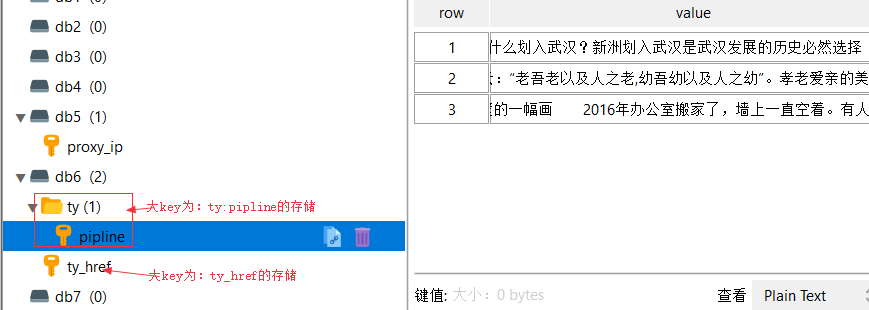

# scrapy分布式

之前写的scrapy只是在一台机器上跑的，其性能存在上限。用多台机器跑scrapy的项目，一起爬去某个网址，每台机器访问这个网站的不同url，同时爬取不同的数据，就是分布式。

## 分布式思想

每个机器都会跑相同的scrapy代码，所以每个机器上的start_urls就不能写死，写死会导致每个机器上跑的都是同一个url。就相当于把一份代码在不同机器上同时执行，访问到的url都是重复的，没有分布式的效果。分布式的效果是每台机器上爬取的url和数据是不会重复的。

如何要每台机器上爬取不同的url?

- 一台机器访问初始的url，会从初始url的响应中解析出多个url(可能是详情页url，可能是页码的url)，解析到的url存储到redis中，其他机器从redis拿url进行访问解析，如果解析出其他url，也保存到redis中，供其他机器爬取
- 一台机器解析出待爬去的url，通过redis共享给其他的机器
- redis共享要满足：去重队列、请求队列、启动的url


分布式的执行流程：
1. 多个机器启动，都盯着redis中的启动url(redis_key指定的大key中存放的url)
2. 某台机器先拿到了启动url，进行访问，然后将解析到的其他待访问的url存储到redis中，先去重，在放入请求队列
3. 其他机器从请求队列中拿到url，进行访问，拿响应对象后解析到新的url去重再加入请求队列或者保存数据
4. 依次循环

上述这个流程很熟悉，就是调度器的流程，但是调度器的去重和请求队列是内存层面的，所以要将调度器的去重和请求队列替换为redis。

替换的代码很简单。

## scrapy 调度器源码

可以通过阅读调度器源码知道其执行的逻辑，知道该替换的是哪些地方。

找到源码：
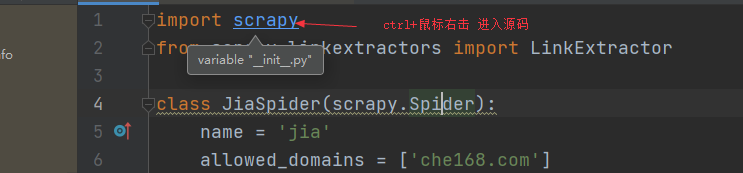
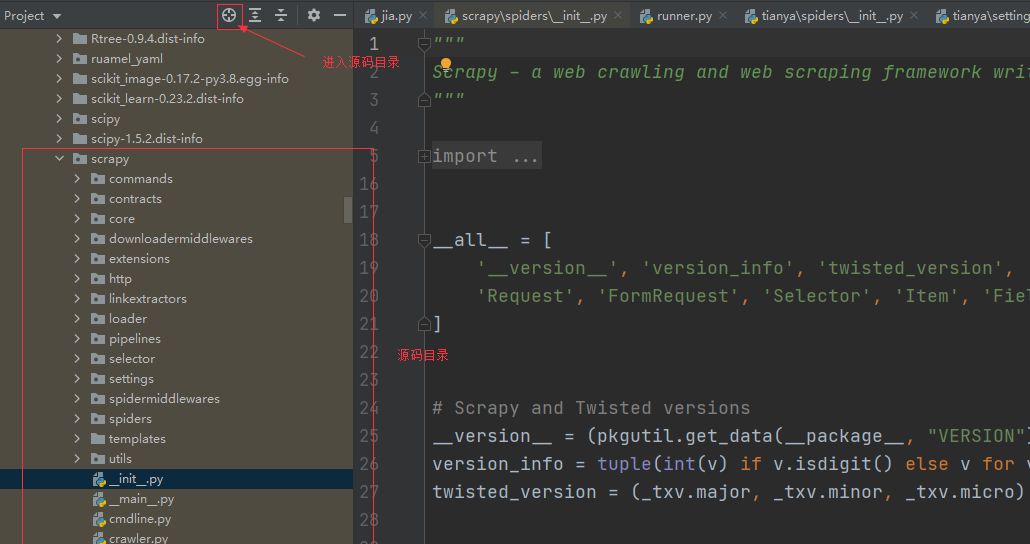

分析：
1. scrapy的核心是引擎，找到引擎文件：`scrapy\core\engine.py`

后续待研究...

### 分布式代码

1.安装依赖包： `pip install scrapy-redis==0.7.2`

我的scrapy版本是2.5.1，对应的scrapy-redis版本就选择0.7.2

2.创建项目，并改造项目代码
- spider的代码

```python
import scrapy
from scrapy_redis.spiders import RedisSpider  # 1. 引入

class Ty2Spider(RedisSpider):  # 2. 替换继承的类为RedisSpider
    name = 'ty2'
    allowed_domains = ['tianya.cn']
    # start_urls = ['http://tianya.cn/']  # 不适用这个作为起始url
    # 3. 分布式爬虫的起始 url
    redis_key = 'ty2:urls'

    def parse(self, resp, **kwargs):
        tbodys = resp.xpath("//div[@class='mt5']/table/tbody")[1:]
        for tbody in tbodys:
            trs = tbody.xpath("./tr")
            for tr in trs:
                title = tr.xpath("./td[1]/a/text()").extract_first()
                href = tr.xpath("./td[1]/a/@href").extract_first()
                href = resp.urljoin(href)
                yield scrapy.Request(url=href, callback=self.parse_detail, meta={"href": href})

    def parse_detail(self, resp, **kwargs):
        txts = resp.xpath("//div[@class='bbs-content clearfix']//text()").extract()  # 解析详情页的内容
        txt = "".join(txts)
        txt = txt.strip()
        print(txts)  # 看看效果
        yield {"content": txt}

```

- settings.py的配置代码

```python
# 4.配置scrapy-redis 不用记住。固定
REDIS_HOST = "127.0.0.1"  # 换成你的IP
REDIS_PORT = 6379  # 端口
REDIS_DB = 8  # 库
REDIS_PARAMS = {
    "password": "123456"  # 密码
}

# scrapy-redis配置信息  # 固定的
# 此时scrapy引擎使用的就不再是默认的调度器了
SCHEDULER = "scrapy_redis.scheduler.Scheduler"

SCHEDULER_PERSIST = True  # 如果为真. 在关闭时自动保存请求信息, 如果为假, 则不保存请求信息
# 此时调度器使用的就是scrapy-redis提供的去重逻辑
DUPEFILTER_CLASS = "scrapy_redis.dupefilter.RFPDupeFilter" # 去重的逻辑. 要用redis的

ITEM_PIPELINES = {
    # scrapy-redis提供了一个存储数据的管道 可用可不用
    'scrapy_redis.pipelines.RedisPipeline': 301  # 配置redis的pipeline
}
```

3.启动项目
- 在redis中添加起始urls
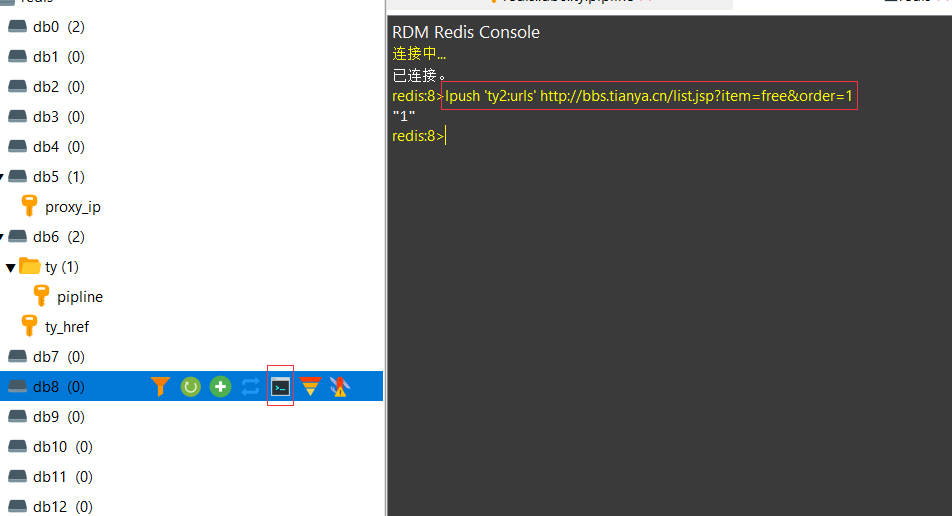
- 多个cmd命令窗口来模拟多个机器
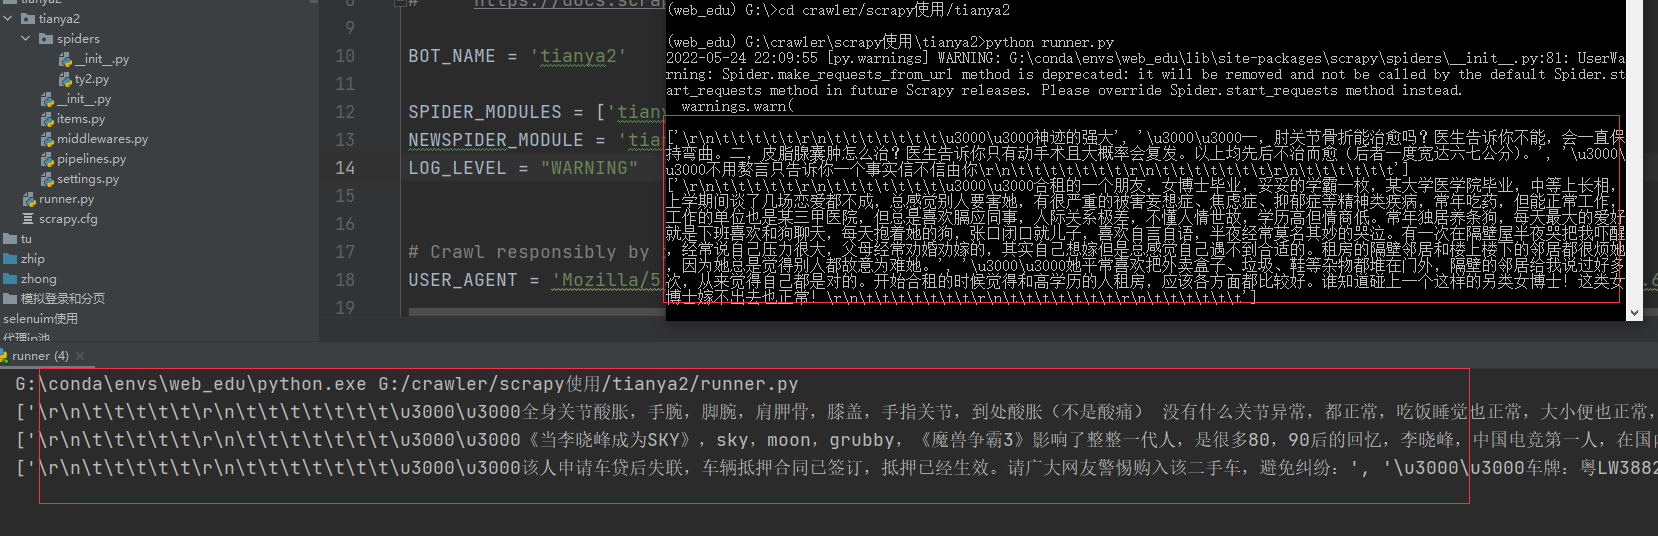

4.关闭项目
- 启动之后，无法自动关闭
- 可以手动ctrl+c进行关闭
- 也可编写复杂的关闭代码进行关闭(待研究)

数据保存
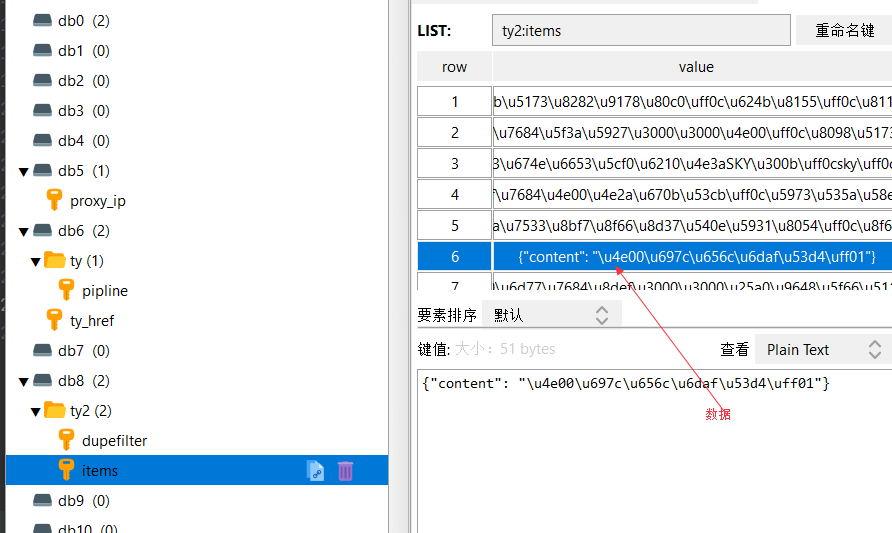

**断点续爬**

当程序没有请求完url时，手动将所有机器上的程序都停掉，会将没有爬取的请求对象保存到redis，当程序启动起来时，会接着跑没有访问到请求对象。
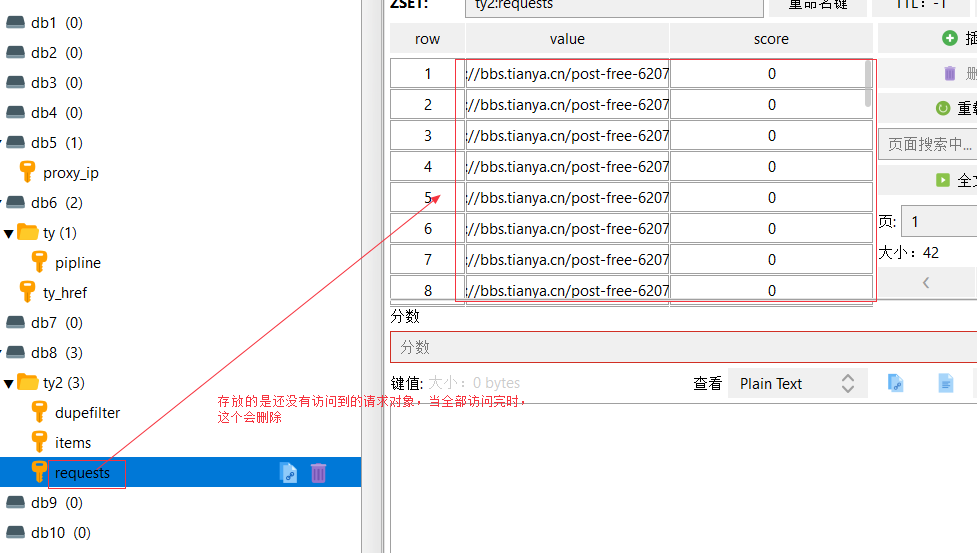
